In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

In [2]:
cod2018 = pd.read_csv('codchamps2018.csv')
cod2019 = pd.read_csv('codchamps2019.csv')

In [3]:
cod2019.head()

,match id,series id,end time,duration (s),mode,map,team,player,win?,score,...,ctrl firstdeaths,ctrl captures,2-piece,3-piece,4-piece,4-streak,5-streak,6-streak,7-streak,8+-streak
0,18392557182634749970,champs-pool-B-2,2019-08-14 17:17:25 UTC,621,Hardpoint,Seaside,Fuego Gaming,BBCONor,W,250,...,0,0,2,0,1,0,0,0,1,0
1,18392557182634749970,champs-pool-B-2,2019-08-14 17:17:25 UTC,621,Hardpoint,Seaside,Fuego Gaming,Chaaxter,W,250,...,0,0,4,0,0,1,0,0,0,0
2,18392557182634749970,champs-pool-B-2,2019-08-14 17:17:25 UTC,621,Hardpoint,Seaside,Fuego Gaming,Harry,W,250,...,0,0,3,2,0,0,0,1,0,0
3,18392557182634749970,champs-pool-B-2,2019-08-14 17:17:25 UTC,621,Hardpoint,Seaside,Fuego Gaming,Hawqeh,W,250,...,0,0,3,0,1,1,0,0,0,0
4,18392557182634749970,champs-pool-B-2,2019-08-14 17:17:25 UTC,621,Hardpoint,Seaside,Fuego Gaming,MadCat,W,250,...,0,0,3,0,0,0,0,0,0,0


In [4]:
cod2019.columns

Index(['match id', 'series id', 'end time', 'duration (s)', 'mode', 'map',
       'team', 'player', 'win?', 'score', 'kills', 'deaths', '+/-', 'k/d',
       'kills per 10min', 'deaths per 10min', 'player score', 'player spm',
       'damage dealt', 'ekia', 'assists', 'headshots', 'suicides',
       'team kills', 'team deaths', 'kills (stayed alive)', 'hits', 'shots',
       'accuracy (%)', 'num lives', 'time alive (s)', 'avg time per life (s)',
       'fave weapon', 'fave specialist', 'fave scorestreaks', 'hill time (s)',
       'hill captures', 'hill defends', 'snd rounds', 'snd firstbloods',
       'snd firstdeaths', 'snd survives', 'bomb pickups', 'bomb plants',
       'bomb defuses', 'bomb sneak defuses', 'snd 1-kill round',
       'snd 2-kill round', 'snd 3-kill round', 'snd 4-kill round',
       'ctrl rounds', 'ctrl firstbloods', 'ctrl firstdeaths', 'ctrl captures',
       '2-piece', '3-piece', '4-piece', '4-streak', '5-streak', '6-streak',
       '7-streak', '8+-streak'],
      

In [5]:
cod2019 = cod2019.drop(columns= ['end time', 'duration (s)', '+/-', 'kills per 10min', 'deaths per 10min', 'player score', 'damage dealt', 'ekia', 'headshots', 'suicides', 'kills (stayed alive)', 'hits', 'shots', 'num lives', 'time alive (s)',  'fave weapon', 'fave specialist', 'fave scorestreaks', 'snd 1-kill round',
       'snd 2-kill round', 'snd 3-kill round', 'snd 4-kill round'])

### Flow
* Data Cleaning
* Feature Engineering 
* Team based 
* Player based
* Team Prediction (Logistic Regression, XGBoost)
* Player Prediction 
* Deploying of code

<b>Data Cleaning</b>

In [6]:
team_names = cod2019['team'].unique()
player_names = cod2019['player'].unique()

In [7]:
for i in range(len(cod2019['match id'].unique())):
    cod2019.loc[cod2019['match id'] == cod2019['match id'].unique()[i], 'match id'] = i+1

In [8]:
for i in range(len(cod2019)):
    cod2019['series id'][i] = cod2019.iloc[i]['series id'][7: -2]

<ipython-input-8-b55057c43189>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cod2019['series id'][i] = cod2019.iloc[i]['series id'][7: -2]


In [9]:
cod2019 = cod2019.rename(columns = {'win?':'result', 'hill time (s)' :'hill time', 'avg time per life (s)' :'avg time per life'})

In [10]:
print("The types of Game Modes played:", cod2019['mode'].unique())

The types of Game Modes played: ['Hardpoint' 'Search & Destroy' 'Control']


Obtaining the relevant Data for each Game Mode played during the tournament

In [11]:
hardpoint = cod2019.loc[cod2019['mode'] == 'Hardpoint']
hardpoint = hardpoint[['match id', 'series id', 'mode', 'map', 'team', 'player', 'result',
       'score', 'kills', 'deaths', 'k/d', 'player spm', 'assists',
       'team kills', 'team deaths', 'accuracy (%)', 'avg time per life',
       'hill time', 'hill captures', 'hill defends','2-piece',
       '3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak',
       '8+-streak']]


control = cod2019.loc[cod2019['mode'] == 'Control']
control = control[['match id', 'series id', 'mode', 'map', 'team', 'player', 'result',
       'score', 'kills', 'deaths', 'k/d', 'player spm', 'assists',
       'team kills', 'team deaths', 'accuracy (%)', 'avg time per life', 'ctrl rounds',
       'ctrl firstbloods', 'ctrl firstdeaths', 'ctrl captures', '2-piece',
       '3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak',
       '8+-streak']]


snd = cod2019.loc[cod2019['mode'] == 'Search & Destroy']
snd = snd[['match id', 'series id', 'mode', 'map', 'team', 'player', 'result',
       'score', 'kills', 'deaths', 'k/d', 'player spm', 'assists',
       'team kills', 'team deaths', 'accuracy (%)', 'avg time per life', 'snd rounds',
       'snd firstbloods', 'snd firstdeaths', 'snd survives', 'bomb pickups',
       'bomb plants', 'bomb defuses', 'bomb sneak defuses', '2-piece',
       '3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak',
       '8+-streak']]

Text(0.5, 1.0, 'Number of games played for each game mode')

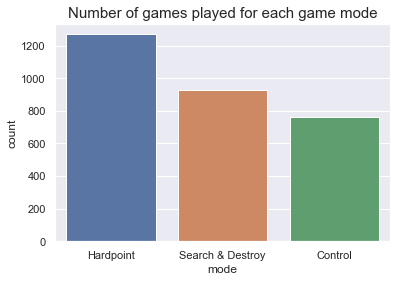

In [12]:
sb.countplot(data=cod2019, x='mode').set_title('Number of games played for each game mode', fontsize=15)

Obtaining the teams statistics across all the games played combined

In [13]:
hardpoint_stats = hardpoint.groupby(by=['team','result'])[['kills', 'deaths','assists','hill time', 'hill captures', 'hill defends','2-piece',
       '3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak', '8+-streak']]
count = hardpoint_stats.size()
hardpoint_stats = hardpoint_stats.sum()
hardpoint_stats['count'] = count
hardpoint_stats.insert(0, 'team', [i for i, j in hardpoint_stats.index])

control_stats = control.groupby(by=['team', 'result'])[['kills', 'deaths', 'assists', 'ctrl rounds',
       'ctrl firstbloods', 'ctrl firstdeaths', 'ctrl captures', '2-piece', '3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak', '8+-streak']]
count = control_stats.size()
control_stats = control_stats.sum()
control_stats['count'] = count
control_stats.insert(0, 'team', [i for i, j in control_stats.index])

snd_stats = snd.groupby(by=['team', 'result'])[['kills', 'deaths', 'assists','snd rounds','snd firstbloods', 'snd firstdeaths', 'snd survives', 'bomb pickups',
       'bomb plants', 'bomb defuses', 'bomb sneak defuses', '2-piece','3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak','8+-streak']]
count = snd_stats.size()
snd_stats = snd_stats.sum()
snd_stats['count'] = count
snd_stats.insert(0, 'team', [i for i, j in snd_stats.index])

# Displaying an example
hardpoint_stats.head()

team  kills  deaths  assists  hill time  \
team           result                                                      
100 Thieves    L          100 Thieves    624     713      279       1857   
               W          100 Thieves   1386    1160      584       4388   
Animosity      L            Animosity    298     460      123        731   
               W            Animosity    110      94       52        461   
Aspire eSports L       Aspire eSports    196     255       70        564   

                       hill captures  hill defends  2-piece  3-piece  4-piece  \
team           result                                                           
100 Thieves    L                 117           202       63       12        1   
               W                 243           344      166       29        2   
Animosity      L                  65            80       32        4        0   
               W                  16            34       15        1        2   
Aspire eSports L                  45            62       26        4        0   

                       4-streak  5-streak  6-streak  7-streak  8+-streak  \
team           result                                                      
100 Thieves    L             16         4         1         0          2   
               W             35        18        10         6          3   
Animosity      L              2         3         0         0          0   
               W              3         1         1         1          0   
Aspire eSports L              5         1         1         0          0   

                       count  
team           result         
100 Thieves    L          30  
               W          60  
Animosity      L          20  
               W           5  
Aspire eSports L          10

In [14]:
teams_list = [i for i in cod2019['team'].unique()]
initial_rating = [1500 for i in teams_list]
teams_rating = pd.DataFrame({'hardpoint rating':initial_rating,'control rating': initial_rating, 'snd rating':initial_rating}, index = teams_list).sort_index()
teams_rating.head()

,hardpoint rating,control rating,snd rating
100 Thieves,1500,1500,1500
Animosity,1500,1500,1500
Aspire eSports,1500,1500,1500
Carnage Gaming,1500,1500,1500
Celtic FC,1500,1500,1500


The next portion of our code involves coming up with a method to determine the team ratings based on a couple of features

* Result w/l
* Kills k
* Deaths d
* Assists a
* 2-4 Piece mk
* 4-6 Streak ls
* 7-8 Streak hs
* Game Mode stats 

$$R_{final} = R_{initial} + \frac{(5 * k) + (1 * a) + (-3 * d) + (50 * w) + (-50 * l) + (10 * mk) + (5 * ls) + (10 * hs) + G_{gamemode}}{games_{won}+games_{lose}}$$

In [15]:
# Creating the rating for hardpoint game mode
def hardpoint_rating(rating, pd):
    for i in range(len(pd)):
        team = pd.iloc[i]
        team_name = pd.iloc[i].name[0]
        result = pd.iloc[i].name[1]
        
        if result == 'W': # Win
            score = team['count'] * 50 + team.kills * 5 + team.assists + team.deaths * -3 
            + (team['2-piece'] + team['3-piece'] + team['4-piece']) * 10 + (team['4-streak'] + team['5-streak'] + team['6-streak']) * 5
            + (team['7-streak'] + team['8+-streak']) * 10 + team['hill time']/5 + (team['hill captures'] + team['hill defends']) * 1
            
        elif result == 'L': # Lose
            score = team['count'] * 50 + team.kills * 5 + team.assists + team.deaths * -3 
            + (team['2-piece'] + team['3-piece'] + team['4-piece']) * 10 + (team['4-streak'] + team['5-streak'] + team['6-streak']) * 5
            + (team['7-streak'] + team['8+-streak']) * 10 + team['hill time']/5 + (team['hill captures'] + team['hill defends']) * 1
        
        # Now we need to balance the rating gains/loss based on the average game performance
        score = score/team['count']
        
        # Updating the score
        rating['hardpoint rating'].loc[rating.index == team_name] += int(score)
    return rating

In [16]:
# Lets see the result
teams_rating = hardpoint_rating(teams_rating, hardpoint_stats)
teams_rating.head(3)

,hardpoint rating,control rating,snd rating
100 Thieves,1709,1500,1500
Animosity,1675,1500,1500
Aspire eSports,1694,1500,1500


Great! Let us now repeat this for Control and Snd 

Note: Do not rerun the same function or the rating will double count

In [17]:
def control_rating(rating, pd):
    for i in range(len(pd)):
        team = pd.iloc[i]
        team_name = pd.iloc[i].name[0]
        result = pd.iloc[i].name[1]
        
        if result == 'W': # Win
            score = team['count'] * 50 + team.kills * 5 + team.assists + team.deaths * -3 
            + (team['2-piece'] + team['3-piece'] + team['4-piece']) * 10 + (team['4-streak'] + team['5-streak'] + team['6-streak']) * 5
            + (team['7-streak'] + team['8+-streak']) * 10 + team['ctrl firstbloods'] * 3 + team['ctrl firstdeaths'] * -3 + team['ctrl captures'] * 1
            
        elif result == 'L': # Lose
            score = team['count'] * 50 + team.kills * 5 + team.assists + team.deaths * -3 
            + (team['2-piece'] + team['3-piece'] + team['4-piece']) * 10 + (team['4-streak'] + team['5-streak'] + team['6-streak']) * 5
            + (team['7-streak'] + team['8+-streak']) * 10 + team['ctrl firstbloods'] * 3 + team['ctrl firstdeaths'] * -3 + team['ctrl captures'] * 1
        
        # Now we need to balance the rating gains/loss based on the average game performance
        score = score/team['count']
        
        # Updating the score
        rating['control rating'].loc[rating.index == team_name] += int(score)
    return rating


def snd_rating(rating, pd):
    for i in range(len(pd)):
        team = pd.iloc[i]
        team_name = pd.iloc[i].name[0]
        result = pd.iloc[i].name[1]
        
        if result == 'W': # Win
            score = team['count'] * 50 + team.kills * 5 + team.assists + team.deaths * -3 
            + (team['2-piece'] + team['3-piece'] + team['4-piece']) * 10 + (team['4-streak'] + team['5-streak'] + team['6-streak']) * 5
            + (team['7-streak'] + team['8+-streak']) * 10 + team['snd firstbloods'] * 5 + team['snd firstdeaths'] * -5 + team['snd survives'] * 1 + team['bomb plants'] * 1 + team['bomb defuses'] * 1 + team['bomb sneak defuses'] * 5
            
        elif result == 'L': # Lose
            score = team['count'] * 50 + team.kills * 5 + team.assists + team.deaths * -3 
            + (team['2-piece'] + team['3-piece'] + team['4-piece']) * 10 + (team['4-streak'] + team['5-streak'] + team['6-streak']) * 5
            + (team['7-streak'] + team['8+-streak']) * 10 + team['snd firstbloods'] * 5 + team['snd firstdeaths'] * -5 + team['snd survives'] * 1 + team['bomb plants'] * 1 + team['bomb defuses'] * 1 + team['bomb sneak defuses'] * 5
        
        # Now we need to balance the rating gains/loss based on the average game performance
        score = score/team['count']
        
        # Updating the score
        rating['snd rating'].loc[rating.index == team_name] += int(score)
    return rating

In [18]:
teams_rating = control_rating(teams_rating, control_stats)
teams_rating = snd_rating(teams_rating, snd_stats)
teams_rating.head(3)

,hardpoint rating,control rating,snd rating
100 Thieves,1709,1686,1635
Animosity,1675,1681,1558
Aspire eSports,1694,1672,1553


<b>Great!</b> Now that we have our teams ELO rating lets try to visualise this and then make some predictions

<AxesSubplot:xlabel='snd rating', ylabel='Count'>

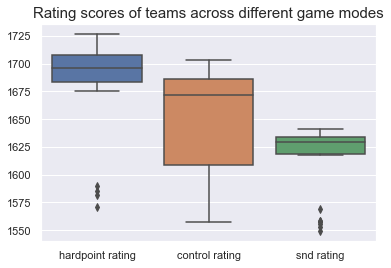

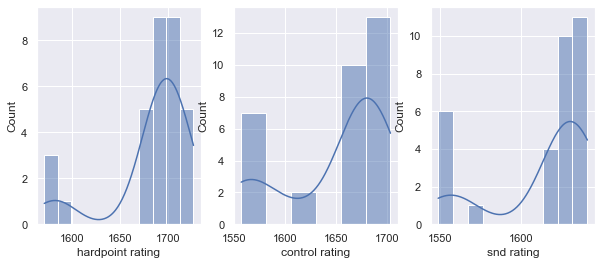

In [19]:
sb.boxplot(data = teams_rating).set_title('Rating scores of teams across different game modes', fontsize = 15)
f, axes = plt.subplots(1, 3, figsize = (10,4))
sb.histplot(teams_rating['hardpoint rating'],kde=True, ax=axes[0])
sb.histplot(teams_rating['control rating'],kde=True, ax=axes[1])
sb.histplot(teams_rating['snd rating'],kde=True, ax=axes[2])

Clearly we can see Hardpoint > Control > SND. Lets try to normalize these scores simply by making the average the same

In [20]:
difference = [i - 1500 for i in teams_rating.mean()]
teams_rating['hardpoint rating'] -= difference[0]
teams_rating['control rating'] -= difference[1]
teams_rating['snd rating'] -= difference[2]
teams_rating.head()

,hardpoint rating,control rating,snd rating
100 Thieves,1524.4375,1535.8125,1520.78125
Animosity,1490.4375,1530.8125,1443.78125
Aspire eSports,1509.4375,1521.8125,1438.78125
Carnage Gaming,1516.4375,1417.8125,1441.78125
Celtic FC,1491.4375,1412.8125,1442.78125


Text(0.5, 1.0, 'Rating scores of teams across different game modes')

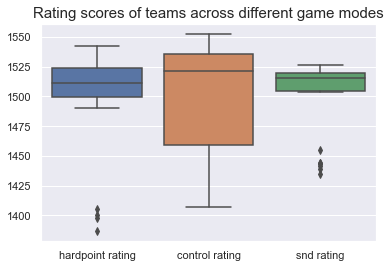

In [21]:
sb.boxplot(data = teams_rating).set_title('Rating scores of teams across different game modes', fontsize = 15)

Now with our team ratings, lets us do some further cleaning

In [22]:
cod2019team = cod2019.copy()
cod2019team = cod2019team.merge(teams_rating, left_on='team', right_on=teams_rating.index)
cod2019team = cod2019team[['match id', 'series id', 'mode', 'result','hardpoint rating', 'control rating', 'snd rating']]
cod2019team.head()

,match id,series id,mode,result,hardpoint rating,control rating,snd rating
0,1,pool-B,Hardpoint,W,1498.4375,1414.8125,1512.78125
1,1,pool-B,Hardpoint,W,1498.4375,1414.8125,1512.78125
2,1,pool-B,Hardpoint,W,1498.4375,1414.8125,1512.78125
3,1,pool-B,Hardpoint,W,1498.4375,1414.8125,1512.78125
4,1,pool-B,Hardpoint,W,1498.4375,1414.8125,1512.78125


Let us encode the result

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cod2019team['result'] = le.fit_transform(cod2019team['result'])
cod2019team.head()

,match id,series id,mode,result,hardpoint rating,control rating,snd rating
0,1,pool-B,Hardpoint,1,1498.4375,1414.8125,1512.78125
1,1,pool-B,Hardpoint,1,1498.4375,1414.8125,1512.78125
2,1,pool-B,Hardpoint,1,1498.4375,1414.8125,1512.78125
3,1,pool-B,Hardpoint,1,1498.4375,1414.8125,1512.78125
4,1,pool-B,Hardpoint,1,1498.4375,1414.8125,1512.78125


Ranking the importance of the Series ID / Stage of Tournament

In [24]:
cod2019team['series id'].loc[cod2019team['series id'].str.contains('pool')] = "1"
cod2019team['series id'].loc[cod2019team['series id'].str.contains('losers')] = [str(int(i) + 1) for i in cod2019team['series id'].loc[cod2019team['series id'].str.contains('losers')].str[-1]]
cod2019team['series id'].loc[cod2019team['series id'].str.contains('winners')] = [str(int(i) + 3) for i in cod2019team['series id'].loc[cod2019team['series id'].str.contains('winners')].str[-1]]
cod2019team['series id'].loc[cod2019team['series id'].str.contains('grand')] = "8"
cod2019team['series id'] = pd.to_numeric(cod2019team['series id'])
cod2019team

C:\Users\yihao\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,match id,series id,mode,result,hardpoint rating,control rating,snd rating
0,1,1,Hardpoint,1,1498.4375,1414.8125,1512.78125
1,1,1,Hardpoint,1,1498.4375,1414.8125,1512.78125
2,1,1,Hardpoint,1,1498.4375,1414.8125,1512.78125
3,1,1,Hardpoint,1,1498.4375,1414.8125,1512.78125
4,1,1,Hardpoint,1,1498.4375,1414.8125,1512.78125
...,...,...,...,...,...,...,...
2955,266,4,Control,0,1523.4375,1515.8125,1514.78125
2956,266,4,Control,0,1523.4375,1515.8125,1514.78125
2957,266,4,Control,0,1523.4375,1515.8125,1514.78125
2958,266,4,Control,0,1523.4375,1515.8125,1514.78125


We will perform a One Hot Encoding on the mode to get 3 different columns

In [25]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
cod2019team = pd.concat([cod2019team, pd.DataFrame(ohc.fit_transform(cod2019team[['mode']]).toarray())], axis=1).rename(columns = {0:"control", 1:"hardpoint", 2:"snd"})
cod2019team = cod2019team.drop(columns = 'mode')
cod2019team.head()

,match id,series id,result,hardpoint rating,control rating,snd rating,control,hardpoint,snd
0,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0
1,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0
2,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0
3,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0
4,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0


Lets try to make some predictions now with the result

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cod2019team[['series id', 'hardpoint rating', 'control rating', 'snd rating', 'control', 'hardpoint', 'snd']], cod2019team['result'], test_size = 0.25)
print("Train:", X_train.shape[0], "\nTest:", X_test.shape[0])

Train: 2220 
Test: 740


In [27]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fitting the model
lr.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making our predictions
y_pred = lr.predict(X_test)
xgb_pred = xgb.predict(X_test)


print("Logistic Regression Score:", lr.score(X_test, y_test))
print("XGBoost Score:", accuracy_score(y_test, xgb_pred))

Logistic Regression Score: 0.5378378378378378
XGBoost Score: 0.7635135135135135


We can see that clearly XGBoost is better. Lets try to improve our dataset

In [28]:
def enemyhardpoint(cod2019team):
    enemy_score = []
    for i in range(len(cod2019team)):
        ID = int(cod2019team.iloc[i]['match id'])
        scores = cod2019team.loc[cod2019team['match id'] == ID]['hardpoint rating'].unique()
        enemy_score.append(np.setdiff1d(scores, cod2019team.iloc[i]['hardpoint rating'])[0])
    return enemy_score


def enemycontrol(cod2019team):
    enemy_score = []
    for i in range(len(cod2019team)):
        ID = int(cod2019team.iloc[i]['match id'])
        scores = cod2019team.loc[cod2019team['match id'] == ID]['control rating'].unique()
        # Check for potential teams with same rating
        if len(np.setdiff1d(scores, cod2019team.iloc[i]['control rating'])) != 0:
            enemy_score.append(np.setdiff1d(scores, cod2019team.iloc[i]['control rating'])[0])
        else:
            enemy_score.append(cod2019team.iloc[i]['control rating'])
    return enemy_score


def enemysnd(cod2019team):
    enemy_score = []
    for i in range(len(cod2019team)):
        ID = int(cod2019team.iloc[i]['match id'])
        scores = cod2019team.loc[cod2019team['match id'] == ID]['snd rating'].unique()
        enemy_score.append(np.setdiff1d(scores, cod2019team.iloc[i]['snd rating'])[0])
    return enemy_score

cod2019team['enemy hardpoint'] = enemyhardpoint(cod2019team)
cod2019team['enemy snd'] = enemysnd(cod2019team)
cod2019team['enemy control'] = enemycontrol(cod2019team)

In [29]:
cod2019team

,match id,series id,result,hardpoint rating,control rating,snd rating,control,hardpoint,snd,enemy hardpoint,enemy snd,enemy control
0,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0,1400.4375,1521.78125,1544.8125
1,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0,1400.4375,1521.78125,1544.8125
2,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0,1400.4375,1521.78125,1544.8125
3,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0,1400.4375,1521.78125,1544.8125
4,1,1,1,1498.4375,1414.8125,1512.78125,0.0,1.0,0.0,1400.4375,1521.78125,1544.8125
...,...,...,...,...,...,...,...,...,...,...,...,...
2955,266,4,0,1523.4375,1515.8125,1514.78125,1.0,0.0,0.0,1524.4375,1520.78125,1535.8125
2956,266,4,0,1523.4375,1515.8125,1514.78125,1.0,0.0,0.0,1524.4375,1520.78125,1535.8125
2957,266,4,0,1523.4375,1515.8125,1514.78125,1.0,0.0,0.0,1524.4375,1520.78125,1535.8125
2958,266,4,0,1523.4375,1515.8125,1514.78125,1.0,0.0,0.0,1524.4375,1520.78125,1535.8125


With our enemy score lets see if we can make better predictions

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cod2019team[['series id', 'hardpoint rating', 'control rating', 'snd rating', 'control', 'hardpoint', 'snd', 'enemy hardpoint', 'enemy snd', 'enemy control']], cod2019team['result'], test_size = 0.25)
print("Train:", X_train.shape[0], "\nTest:", X_test.shape[0])

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
rf = RandomForestClassifier(n_jobs=10, n_estimators=50)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fitting the model
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making our predictions
y_pred = lr.predict(X_test)
y_pred2 = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)


print("")
print("Logistic Regression Score:", lr.score(X_test, y_test))
print("Random Forest Score:", rf.score(X_test, y_test))
print("XGBoost Score:", accuracy_score(y_test, xgb_pred))

Train: 2220 
Test: 740

Logistic Regression Score: 0.6932432432432433
Random Forest Score: 0.827027027027027
XGBoost Score: 0.8256756756756757


Clearly the scores have improved on both models! Let us optimize the parameters for XGBoost with GridSearchCV

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(eval_metric='auc', use_label_encoder=False, learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

C:\Users\yihao\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 9, 'min_child_weight': 1}, 0.9668849472712224)

Let us try to predict which teams would win if pit against each other

In [100]:
teamresult = cod2019.copy()
teamresult = teamresult.merge(teams_rating, left_on='team', right_on=teams_rating.index)
teamresult = teamresult[['team', 'match id', 'series id', 'mode', 'result']]

teamresult['result'] = le.fit_transform(teamresult['result'])
match_result = teamresult.groupby(by=['match id', 'team']).sum()/5

matchid = []
team = []
for i in match_result.index:
    matchid.append(i[0])
    team.append(i[1])

match_result['team'] = team
match_result['match id'] = matchid
match_result['index'] = [i for i in range(592)]

match_result = match_result.set_index('index')
match_result.head()

,result,team,match id
index,,,
0,1.0,Fuego Gaming,1
1,0.0,Gen.G,1
2,1.0,Celtic FC,2
3,0.0,Elevate,2
4,1.0,Enigma6,3


In [101]:
def enemyteam(cod2019team):
    enemy_score = []
    for i in range(len(cod2019team)):
        ID = int(cod2019team.iloc[i]['match id'])
        scores = cod2019team.loc[cod2019team['match id'] == ID]['team'].unique()
        enemy_score.append(np.setdiff1d(scores, cod2019team.iloc[i]['team'])[0])
    return enemy_score

match_result['enemy team'] = enemyteam(match_result)
match_result.head(5)

,result,team,match id,enemy team
index,,,,
0,1.0,Fuego Gaming,1,Gen.G
1,0.0,Gen.G,1,Fuego Gaming
2,1.0,Celtic FC,2,Elevate
3,0.0,Elevate,2,Celtic FC
4,1.0,Enigma6,3,Team WaR


In [116]:
myteam = pd.DataFrame(ohc.fit_transform(match_result[['team']]).toarray())
enemiesteam = pd.DataFrame(ohc.fit_transform(match_result[['enemy team']]).toarray(), columns=[i+32 for i in range(32)])

match_result = pd.concat([match_result, myteam, enemiesteam], axis=1)
match_result.head(5)

,result,team,match id,enemy team,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
0,1.0,Fuego Gaming,1,Gen.G,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,Gen.G,1,Fuego Gaming,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,Celtic FC,2,Elevate,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,Elevate,2,Celtic FC,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,Enigma6,3,Team WaR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [117]:
y = match_result['result']
X = match_result.drop(columns=['result', 'team', 'enemy team', 'match id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fitting the model
xgb.fit(X_train, y_train)

# Making our predictions
xgb_pred = xgb.predict(X_test)


print("")
print("XGBoost Score:", accuracy_score(y_test, xgb_pred))

ValueError: feature_names must be unique